In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('../../datasets/tokenized/blog_auth_5k.csv', encoding='utf-8')
df = df.drop('word_length_distribution', axis=1)
df.head(3)

,text,gender,age_group,n_words,tokenized,n_characters,n_tokens,n_long_tokens,n_types,n_sentences,avg_characters_per_word,std_characters_per_word,ratio_long_words,avg_words_per_sentence,std_words_per_sentence
0,"""I don't want to start any blasphemous rumours...",male,<35,29,""" i do n't want to start any blasphemous rumou...",144,31,26,27,1,3.61290,2.26094,0.83871,31.00000,0.00000
1,Went blueberry picking on monday. Tried to get...,female,<35,509,went blueberry picking on monday . tried to ge...,2760,522,404,298,34,4.11303,2.20901,0.77395,15.35294,9.62913
2,"So, i got this in my e-mail today. For those o...",female,<35,447,"so , i got this in my e - mail today . for tho...",2455,465,344,251,32,4.13978,2.37530,0.73978,14.53125,8.42800


In [3]:
enc = LabelEncoder()
enc.fit(df['age_group'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df['age_group'] = enc.transform(df['age_group'])
encoded_labels

{'<35': 0, '>35': 1}

In [4]:
df['age_group'].value_counts()

0    4603
1    1097
Name: age_group, dtype: int64

## On initial data

In [5]:
X = df.drop(['age_group', 'text'], axis=1)
y = df['age_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=97, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4560, 13), (1140, 13), (4560,), (1140,))

In [6]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [19]:
word_23_tf = TfidfVectorizer(ngram_range=(1, 3), max_features=5000, stop_words=None)
char_23_tf = TfidfVectorizer(analyzer='char', ngram_range=(1, 3), max_features=5000, stop_words=None)

word_pipe = Pipeline([
    ('selector', ItemSelector(key='tokenized')),
    ('tfidf', word_23_tf)
])

char_pipe = Pipeline([
    ('selector', ItemSelector(key='tokenized')),
    ('tfidf', char_23_tf)
])

num_cols = df.drop(['age_group', 'text', 'tokenized', 'gender'], axis=1).columns 
num_pipe = Pipeline([
    ('selector', ItemSelector(key=num_cols))
])

pipe = Pipeline([
    ('feats', FeatureUnion([  
            ('word_pipeline', word_pipe),
            ('char_pipeline', char_pipe),
            ("num_pipeline", num_pipe)
          ]),
    ),
    ('clf', SVC(random_state=97, class_weight={0: .2, 1: .8}))
])

In [20]:
param_grid = {
    'clf__C': [10**i for i in range(-1, 4)]
}

In [21]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'clf__C': 1000}


In [22]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       921
           1       0.27      0.21      0.24       219

    accuracy                           0.74      1140
   macro avg       0.55      0.54      0.54      1140
weighted avg       0.72      0.74      0.73      1140



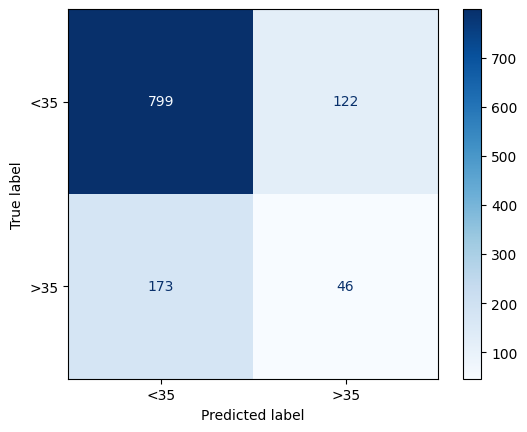

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues')
disp.ax_.tick_params(axis='x');